In [1]:
# Getting in working order
# - Add a reset button
# - Update for frequency
# - Restart on state mod
# Label with wave equation; period
# Figure out confusing parts
# Pretty up
# - Display values in pi
# - Tighten up layout
# - Use richburke.bot colors(?)
# Clean up code
# - init_func
# - fargs
# - does anything benefit from being an object
#   - state
#   - plot
#   - animation
# - initialize ui and plot with initial state
# - move slider to its own file
# - move calculation to its own file
# Write descriptions
# - https://mathbitsnotebook.com/Algebra2/TrigGraphs/TGTrigVocab.html

%matplotlib widget
from operator import itemgetter
from enum import Enum
import numpy as np
from ipywidgets import Box, Button, FloatSlider, HBox, interactive_output, Label, Layout, Output, ToggleButtons, VBox
# from IPython.display import clear_output
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

In [2]:
MIN_X = np.pi * -2
MAX_X = np.pi * 4
MIN_Y = -3
MAX_Y = 3

class StateProp(Enum):
    MODIFIED = 'modified'
    TRIG_FUNCTION = 'trig_function'
    PHASE_SHIFT = 'phase_shift'
    VERTICAL_SHIFT = 'vertical_shift'
    HORIZONTAL_SCALAR = 'horizontal_scalar'
    VERTICAL_SCALAR = 'vertical_scalar'

class SliderProp(Enum):
    DESCRIPTION = 'description'
    VALUE = 'value'
    MIN = 'min'
    MAX = 'max'
    STEP = 'step'

class ToggleButtonOption(Enum):
    SINE = 'sine'
    COSINE = 'cosine'

class AnimatedPart(Enum):
    CIRCLE = 'circle'
    INNER_CIRCLE = 'inner_circle'
    PERIOD_WAVE = 'period_wave'
    FULL_WAVE = 'full_wave'
    POINT = 'point'
    TERMINAL_ARM = 'terminal_arm'
    CONNECTING_ARM = 'connecting_arm'

state_defaults = {
    StateProp.MODIFIED: False,
    StateProp.TRIG_FUNCTION: ToggleButtonOption.SINE,
    StateProp.PHASE_SHIFT: 0,
    StateProp.VERTICAL_SHIFT: 0,
    StateProp.HORIZONTAL_SCALAR: 1,
    StateProp.VERTICAL_SCALAR: 1,
}

state = {}
state.update(state_defaults)

def update_state(state):
    def fn(trig_function, phase_shift, vertical_shift, horizontal_scalar, vertical_scalar):
        state[StateProp.TRIG_FUNCTION] = trig_function
        # state["reset"] = reset
        state[StateProp.PHASE_SHIFT] = phase_shift
        state[StateProp.VERTICAL_SHIFT] = vertical_shift
        state[StateProp.HORIZONTAL_SCALAR] = horizontal_scalar
        state[StateProp.VERTICAL_SCALAR] = vertical_scalar
    return fn


# def reset_state(state):
#     updater = update_state(state)
#     def fn(_event):
#         trig_function, phase_shift, vertical_shift, horizontal_scalar, vertical_scalar = itemgetter(
#             StateProp.TRIG_FUNCTION,
#             StateProp.PHASE_SHIFT,
#             StateProp.VERTICAL_SHIFT,
#             StateProp.HORIZONTAL_SCALAR,
#             StateProp.VERTICAL_SCALAR,
#         )(state_defaults)
#         print(vertical_scalar)
#         updater(
#             trig_function,
#             phase_shift,
#             vertical_shift,
#             horizontal_scalar,
#             vertical_scalar 
#         )
#     return fn


TWO_PI = np.pi * 2
def period(interval=TWO_PI):
    def fn(frequency=1):
        return interval / frequency
    return fn


def wave_at(fnc):
    def fn(amplitude=1, frequency=1, horizontal_shift=0, vertical_shift=0):
        def gn(x):
            return (amplitude * fnc(frequency * (x - horizontal_shift))) + vertical_shift
        return gn
    return fn


def wave(fnc):
    def fn(amplitude=1, frequency=1, horizontal_shift=0, vertical_shift=0):
        def gn(t):
            return (amplitude * fnc(frequency * (t - horizontal_shift))) + vertical_shift
        return gn
    return fn


def update_label(label):
    def fn(change):
        value = change['new']
        label.value = f"{value:.1f}"
    return fn


def define_slider(options):
    description, value, min, max, step = itemgetter(
        SliderProp.DESCRIPTION,
        SliderProp.VALUE,
        SliderProp.MIN,
        SliderProp.MAX,
        SliderProp.STEP,
    )(options)

    slider = FloatSlider(
        value=value,
        min=min,
        max=max,
        step=step,
        orientation='horizontal',
        readout=False,
        continuous_update=False
    )

    label = Label(description)
    label.layout.width = '8rem'
    
    label_value = Label(f"{value:.1f}")
    label_value.layout.width = '3rem'
    label_value.layout.margin = '2px 0 0 1rem'
    label_value.layout.justify_content = 'flex-end'

    label_min = Label(f"{min:.1f}")
    label_min.style.text_color = 'gray'

    label_max = Label(f"{max:.1f}")
    label_max.style.text_color = 'gray'

    slider.observe(update_label(label_value), names="value")

    slider_container = HBox([label_min, slider, label_max])
    slider_container.layout.justify_content = 'center'
    container = HBox([label, slider_container, label_value])
    container.layout.justify_content = 'space-between'

    return {'container': container, 'slider': slider}


def define_ui(state):
    # Supply values as ToggleButtonOption.
    toggle_buttons = ToggleButtons(options=["Sine", "Cosine"])
    # reset_button = Button(description="Reset")
    # reset_button.on_click(reset_state(state))
    toggle_buttons_container = Box(
        children=[toggle_buttons],
        layout=Layout(margin='0 0 1rem 0')
    )
    # toggle_buttons_container = Box(
    #     children=[toggle_buttons, reset_button],
    #     layout=Layout(margin='0 0 1rem 0')
    # )

    slider1_layout = define_slider({
        SliderProp.DESCRIPTION: "Phase",
        SliderProp.VALUE: 0,
        SliderProp.MIN: -2,
        SliderProp.MAX: 2,
        SliderProp.STEP: 0.01
    })
    slider2_layout = define_slider({
        SliderProp.DESCRIPTION: "Vertical Shift",
        SliderProp.VALUE: 0,
        SliderProp.MIN: -2,
        SliderProp.MAX: 2,
        SliderProp.STEP: 0.01
    })
    slider3_layout = define_slider({
        SliderProp.DESCRIPTION: "Frequency",
        SliderProp.VALUE: state[StateProp.HORIZONTAL_SCALAR],
        SliderProp.MIN: 0.5,
        SliderProp.MAX: 2,
        SliderProp.STEP: 0.01
    })
    slider4_layout = define_slider({
        SliderProp.DESCRIPTION: "Amplitude",
        SliderProp.VALUE: state[StateProp.VERTICAL_SCALAR],
        SliderProp.MIN: -2,
        SliderProp.MAX: 2,
        SliderProp.STEP: 0.01
    })

    interactive_output(update_state(state), {
        "trig_function": toggle_buttons,
        "phase_shift": slider1_layout['slider'],
        "vertical_shift": slider2_layout['slider'],
        "horizontal_scalar": slider3_layout['slider'], # frequency
        "vertical_scalar": slider4_layout['slider'] # amplitude
    })

    bottom_column = VBox(children=[
        slider1_layout['container'],
        slider2_layout['container'],
        slider3_layout['container'],
        slider4_layout['container'],
    ])
    bottom_column.layout = Layout(
        padding='0.5rem',
        border='1px solid lightgray',
        width='fit-content'
    )

    layout = Layout(
        display='flex',
        flex_flow='column',
        align_items='stretch'
    )
    main_container = Box(children=[toggle_buttons_container, bottom_column], layout=layout)

    return main_container

In [3]:
# @define as Enum props


# @todo "define_plot"
def setup_plot(plt):
    # fig, ax = plt.subplots()
    fig, ax = plt.subplots(gridspec_kw=dict(wspace=0))

    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.canvas.resizable = False

    # theta = np.linspace(MIN_X, MAX_X, 100)

    ax.set_aspect('equal')
    ax.set_xlim(np.pi * -2, np.pi * 4)
    ax.set_ylim(MIN_Y, MAX_Y)

    x_axis_x = [np.pi * -2, np.pi * 4]
    x_axis_y = [0, 0]
    y_axis_x = [0, 0]
    y_axis_y = [MIN_Y, MAX_Y]

    ax.plot(x_axis_x, x_axis_y, color='#666666')
    ax.plot(y_axis_x, y_axis_y, color='#666666')

    # circle = patches.Circle((0, 0), 1, fill=False, color='b')
    # ax.add_patch(circle)

    x = np.linspace(0, 2 * np.pi, 50)
    inner_circle, = ax.plot(0, 0, "#666666", lw=0.3)
    circle = patches.Circle((0, 0), 1, fill=False)
    ax.add_patch(circle)

    period_wave, = ax.plot(0, 0, "b", lw=1.0)
    full_wave, = ax.plot(0, 0, "k", lw=0.3)
    # wave, = ax.plot(np.cos(x) - (2 * np.pi), np.sin(x), "k", lw=0.3)
    point, = ax.plot(-1, 0, ".")
    # terminal_arm = None
    x1 = [0, 1]
    # x1 = [np.cos(x) - 1 / 2, 0]
    y1 = [0, 0]
    terminal_arm, = ax.plot(x1, y1, lw=0.8)
    connecting_arm, = ax.plot([0, 0], [0, 0], lw=0.8)

    # @todo define props
    return {
        'plt': plt,
        'fig': fig,
        'axes': [ax],
        'animated_parts': {
            AnimatedPart.CIRCLE: circle,
            AnimatedPart.INNER_CIRCLE: inner_circle,
            AnimatedPart.POINT: point,
            AnimatedPart.PERIOD_WAVE: period_wave,
            AnimatedPart.FULL_WAVE: full_wave,
            AnimatedPart.TERMINAL_ARM: terminal_arm,
            AnimatedPart.CONNECTING_ARM: connecting_arm
        }
    }




def animate(animated_parts, state):
    global out

    circle, inner_circle, point, period_wave, full_wave, terminal_arm, connecting_arm = itemgetter(
        AnimatedPart.CIRCLE,
        AnimatedPart.INNER_CIRCLE,
        AnimatedPart.POINT,
        AnimatedPart.PERIOD_WAVE,
        AnimatedPart.FULL_WAVE,
        AnimatedPart.TERMINAL_ARM,
        AnimatedPart.CONNECTING_ARM,
    )(animated_parts)

    sine_wave = wave(np.sin)
    cosine_wave = wave(np.cos)
    
    def fn(i):
        # try:
        trig_function, phase_shift, vertical_shift, horizontal_scalar, vertical_scalar = itemgetter(
            StateProp.TRIG_FUNCTION,
            # "reset",
            StateProp.PHASE_SHIFT,
            StateProp.VERTICAL_SHIFT,
            StateProp.HORIZONTAL_SCALAR,
            StateProp.VERTICAL_SCALAR,
        )(state)
        # except Exception:
        #     # @todo HANDLE
        #     print('Ex')

        # print(reset)

        fnc = cosine_wave if trig_function == ToggleButtonOption.COSINE else sine_wave
        wave_function = fnc(vertical_scalar, horizontal_scalar, phase_shift, vertical_shift)

        with out:
            period_start = phase_shift
            period_current = period_start + i
            circle_origin_x = period_current
            circle_origin_y = vertical_shift
            circle_radius = vertical_scalar

            circle.center = (circle_origin_x, circle_origin_y)
            circle.set_radius(circle_radius)

            full_thetas = np.linspace(MIN_X, MAX_X, 100)
            # @todo why these values? why the 25?
            # Perhaps provide constant
            period_thetas = np.linspace(period_start, period_current, int(period_current * 25 / np.pi))
            ys = wave_function(period_thetas)
            # ys = [wave_function(t) for t in period_thetas]
            y2s = wave_function(full_thetas)
            # y2s = [wave_function(t) for t in full_thetas]
            
            period_wave.set_data(period_thetas, ys)
            full_wave.set_data(full_thetas, y2s)
            
            latest_x = cosine_wave(vertical_scalar, horizontal_scalar)(period_current)
            latest_y1 = sine_wave(vertical_scalar, horizontal_scalar)(period_current)
            latest_y = 0 if np.size(ys) == 0 else ys[-1]

            point.set_data([period_current], [latest_y])

            factor = 0.3
            inner_circle_x = circle_origin_x + (np.cos(period_thetas) * factor)
            inner_circle_y = circle_origin_y + (np.sin(period_thetas) * factor)
            inner_circle.set_data(inner_circle_x, inner_circle_y)

            terminal_arm_x1 = 0 if np.size(inner_circle_x) == 0 else inner_circle_x[-1]
            terminal_arm_y1 = 0 if np.size(inner_circle_y) == 0 else inner_circle_y[-1]
            terminal_arm_x2 = circle_origin_x + latest_x
            terminal_arm_y2 = circle_origin_y + latest_y1
            terminal_arm.set_data([terminal_arm_x1, terminal_arm_x2], [terminal_arm_y1, terminal_arm_y2])

            connecting_arm.set_data([terminal_arm_x2, period_current], [terminal_arm_y2, latest_y])

        return circle, inner_circle, point, period_wave, full_wave, terminal_arm, connecting_arm
    return fn


Box(children=(Box(children=(ToggleButtons(options=('Sine', 'Cosine'), value='Sine'),), layout=Layout(margin='0…

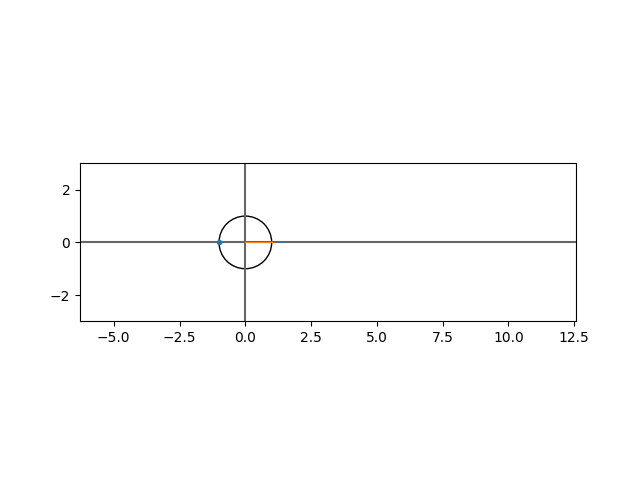

In [4]:
# Proper range
# xs = np.linspace(-np.pi, 4 * np.pi, 100)

# plt.subplots_adjust(wspace=0.0, hspace=0.0)

# plt.style.use('seaborn-v0_8-bright')

out = Output()
# plt.ioff()
ui = define_ui(state)
plot = setup_plot(plt)

# update_state, update_animation


# def get_frames():
#     t = 0.0
#     x = np.linspace(0, 2*np.pi, 100)
#     l, = plt.plot(x, np.sin(x+t))

#     for nt, t in enumerate(np.linspace(0, 2*np.pi, 200)):
#         l.set_data(x, np.sin(x+t))
#         yield l,


x = np.linspace(0, 2 * np.pi, 50)
ani = animation.FuncAnimation(
    plot['fig'],
    # animated_parts
    animate(plot['animated_parts'], state),
    # @todo define constant
    interval=50,
    blit=True,
    frames=x,
    # @todo define constant
    repeat_delay=100,
)

display(ui)
with out:
    display(ani)

In [5]:
# ani.save('./animation.gif', fps=30)
# ani.save('/tmp/animation.gif', writer='imagemagick', fps=30)